In [1]:
%matplotlib inline

In [2]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np
import xyzpy as xyz
import json

In [3]:
def TN_to_eq_shapes(tn):
    """Convert a quimb TN into opt_einsum eq and shapes.
    """
    ts = tn.tensors
    expr = qtn.tensor_contract(*ts, get='expression', optimize='eager')
    eq = expr.contraction
    shapes = [t.shape for t in ts]
    return eq, shapes

def eq_shapes_to_json(eq, shapes, fname):
    """Write eq and shapes to JSON.
    """
    with open(fname, 'w') as file:
        json.dump({'eq': eq, 'shapes': shapes}, file)
        
def eq_shapes_from_json(fname):
    """Load eq and shapes from JSON
    """
    with open(fname) as file:
        loaded = json.load(file)
        eq, shapes = loaded['eq'], loaded['shapes']
    return eq, shapes

# QAOA Maxcut

In [4]:
def rand_reg_graph(reg, n, seed=None):
    import networkx as nx
    G = nx.random_regular_graph(reg, n, seed=seed)
    return G

def graph_to_circ(G, gamma0=-0.743043, beta0 = 0.754082):
    n = G.number_of_nodes()
    
    # add all the gates
    circ = "{}\n".format(n)
    for i in range(n):
        circ += "H {}\n".format(i)
    for i, j in G.edges:
        circ += "CNOT {} {}\n".format(i, j)
        circ += "Rz {} {}\n".format(gamma0, j)
        circ += "CNOT {} {}\n".format(i, j)
    for i in range(n):
        circ += "Rx {} {}\n".format(beta0, i)
        
    return circ

def do_circuit(info):
    qc = qtn.Circuit(info['n'])
    qc.apply_circuit(info['gates'])
    return qc.psi

def psi_gamma_beta_G(n, reg, seed, gamma0, beta0):
    G = rand_reg_graph(reg, n, seed=seed)
    circ = graph_to_circ(G, gamma0=gamma0, beta0=beta0)
    info = qtn.circuit.parse_qasm(circ)
    return do_circuit(info).squeeze(), G

Generate the circuit:

In [52]:
n = 40
reg = 5
seed = 2

psi_f, G = psi_gamma_beta_G(n, reg, seed, gamma0=0.874729, beta0=0.8471024)
s = qtn.MPS_sampler(psi_f.nsites)
norm = s & psi_f

In [53]:
fname = "oe_sample_MAXCUT_n{}_reg{}_seed{}.json".format(n, reg, seed)
print(fname)

eq_shapes_to_json(*TN_to_eq_shapes(norm), fname)

oe_sample_MAXCUT_n40_reg5_seed2.json


### analysis

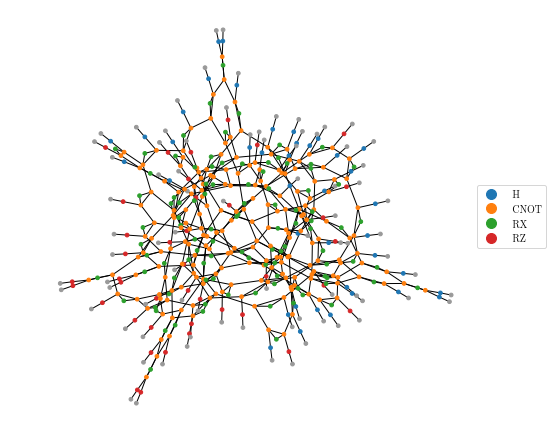

In [55]:
norm.graph(color=['H', 'CNOT', 'RX', 'RZ'])

In [56]:
# the greedy contraction complexity
ccg = norm.contraction_complexity(optimize='greedy')
ccg

27.0

In [57]:
# 100 random eager contraction complexities
ccs = np.array([norm.contraction_complexity(optimize='eager') for _ in xyz.progbar(range(100))])

100%|##########| 100/100 [00:13<00:00,  7.34it/s]


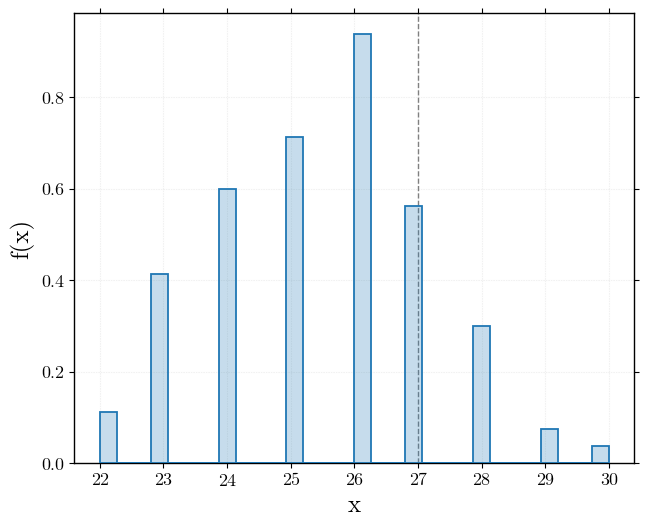

In [60]:
xyz.auto_histogram(ccs, vlines=[ccg])

# MERA examples

In [151]:
n = 256
dangle = 0

mera = qtn.MERA.rand(n, dangle=dangle)
norm = mera.H & mera

In [152]:
fname = "oe_sample_MERAFULL_n{}_dangle{}.json".format(n, dangle)
print(fname)

eq_shapes_to_json(*TN_to_eq_shapes(norm), fname)

oe_sample_MERAFULL_n256_dangle0.json


### analysis

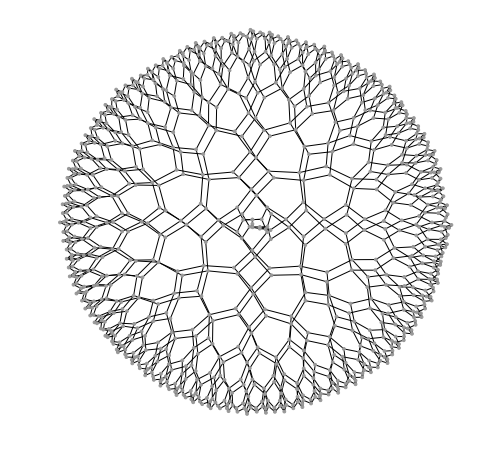

In [153]:
norm.graph()

In [154]:
# the greedy contraction complexity
ccg = norm.contraction_complexity(optimize='greedy')
ccg

29.0

In [155]:
# 100 random eager contraction complexities
ccs = np.array([norm.contraction_complexity(optimize='eager') for _ in xyz.progbar(range(100))])

100%|##########| 100/100 [00:51<00:00,  1.95it/s]


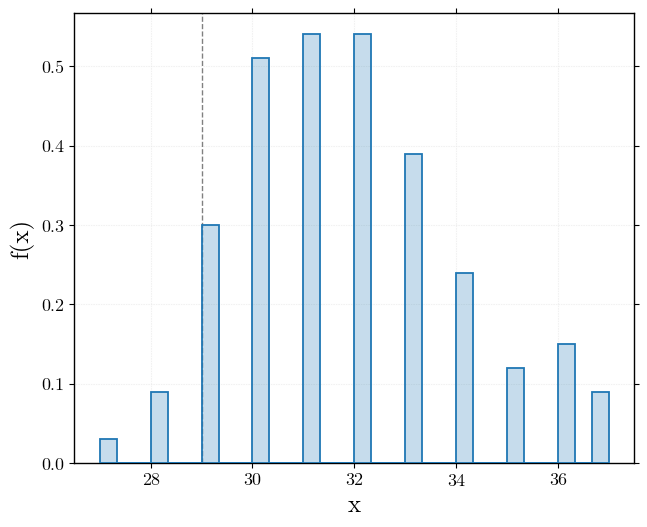

In [156]:
xyz.auto_histogram(ccs, vlines=[ccg])

# Google random circuit examples

These requires the repo https://github.com/sboixo/GRCS to be downloaded and the
files inside untarred at a location set here:

In [107]:
GCRS_directory = "/home/johnnie/src/GRCS/"

In [179]:
w, h = 5, 5
d = 30
inst = 2

In [180]:
qasm_file = GCRS_directory + f"inst/cz_v2/{w}x{h}/inst_{w}x{h}_{d}_{inst}.txt"

In [181]:
qc = qtn.Circuit.from_qasm_file(qasm_file, strip_round=True)
s = qtn.MPS_sampler(qc.N)
norm = s & qc.psi

In [182]:
fname = f"oe_sample_GOOGLERAND_w{w}h{h}_d{d}_inst{inst}.json"
print(fname)

eq_shapes_to_json(*TN_to_eq_shapes(norm), fname)

oe_sample_GOOGLERAND_w5h5_d30_inst2.json


### analysis

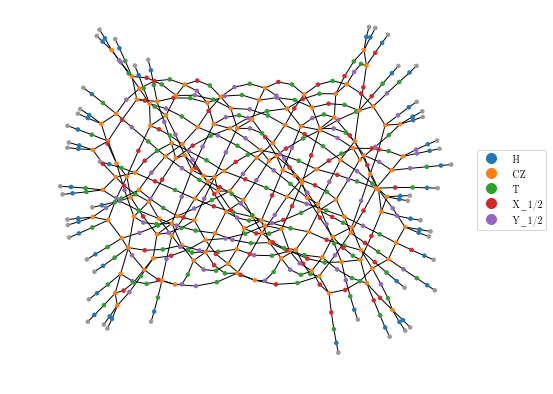

In [183]:
norm.graph(color=['H', 'CZ', 'T', 'X_1/2', 'Y_1/2'])

In [184]:
# the greedy contraction complexity
ccg = norm.contraction_complexity(optimize='greedy')
ccg

32.0

In [185]:
# 100 random eager contraction complexities
ccs = np.array([norm.contraction_complexity(optimize='eager') for _ in xyz.progbar(range(100))])

100%|##########| 100/100 [00:17<00:00,  5.86it/s]


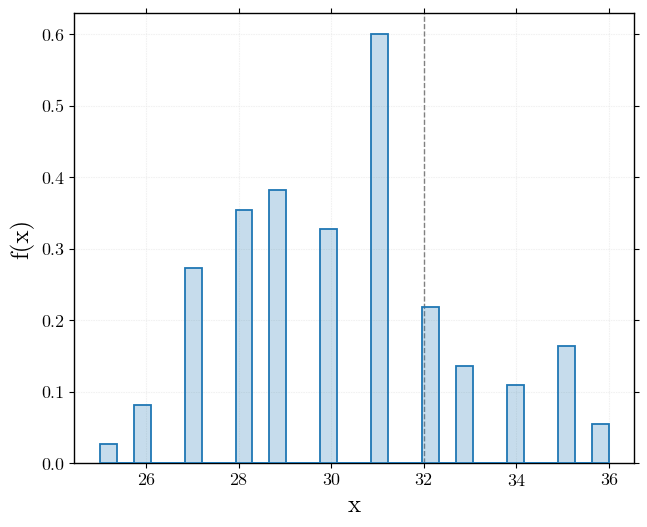

In [186]:
xyz.auto_histogram(ccs, vlines=[ccg])